In [1]:
using Pkg
Pkg.activate("C:/Users/ibzja/Documents/UPF_2022_2026/4t/2n_trimestre/Practiques_tutelades/CellBasedModels.jl")
using CellBasedModels 
using GeometryBasics
using Distributions
using GLMakie
Makie.inline!(true)

  Activating project at `C:\Users\ibzja\Documents\UPF_2022_2026\4t\2n_trimestre\Practiques_tutelades\CellBasedModels.jl`


true

# Change to moving source

In [2]:
function plotRods2D!(ax, x, y, d, l, angle; kargs...)

    Main.meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )

    Main.meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=[Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotation=angle,
                kargs...
            )

    return

end

function plotRods2D!(ax, x, y, xs1, ys1, xs2, ys2, markerSphere, markerCylinder, angle; kargs...)

    m = meshscatter!(ax,
                xs1,
                ys1,
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=markerSphere;
                kargs...
            )

    Main.meshscatter!(ax,
                xs2,
                ys2,
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=markerSphere;
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=markerCylinder,
                rotation=angle;
                kargs...
            )

    return m

end

plotRods2D! (generic function with 2 methods)

In [7]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :theta => Float64,
        :ω => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        :tTumble => Float64,
        :active => Bool,

        :isSource => Bool,
        :S => Float64,

    ),

    model = Dict(
        :kn => Float64,
        :γn => Float64,
        :γt => Float64,
        :μcc => Float64,
        :μcw => Float64,
        :β => Float64,
        :βω => Float64,
        :ωTumble => Float64,
        :τTumble => Float64,
        :fChem => Float64,
        :DMedium => Float64,
        :DSource => Float64 #Diffusion of source for the random walk
    ),

    medium = Dict(
        :mm => Float64
    ),

    agentODE = quote
        fx = 0.0
        fy = 0.0
        W = 0.0
        pressure = 0.0

        @loopOverNeighbors j begin
            Fijx, Fijy, Wij = CBMModels.rodForces(
                x, y, d, l, theta, vx, vy, m,
                x[j], y[j], d[j], l[j], theta[j], vx[j], vy[j], m[j],
                kn, γn, γt, μcc, μcw
            )

            fx += Fijx
            fy += Fijy
            W += Wij
            pressure += sqrt(Fijx^2 + Fijy^2)
        end

        dt(x) = vx
        dt(y) = vy
        dt(vx) = -β * vx + fx / m + active * fChem * cos(theta)
        dt(vy) = -β * vy + fy / m + active * fChem * sin(theta)
        dt(theta) = ω
        dt(ω) = W / (m * (d + l)^2 / 12 + m * d^2) - βω * ω
    end,

    agentRule = quote

        if isSource
            σ = sqrt(2 * DSource / dt)

            vx = σ * randn()
            vy = σ * randn()
            ω = 0.0

            mm += S
        end

        if tTumble < t && active
            vx = 0.0
            vy = 0.0
            active = false
            ω += ωTumble
            tTumble += 1.0
        elseif tTumble < t && !active
            ω = 0.0
            active = true
            tTumble += CBMDistributions.exponential((2 - mm) * τTumble)
        end
 
        if x < simBox[1,1]
            x = simBox[1,1]
        elseif x > simBox[1,2]
            x = simBox[1,2]
        end
        if y < simBox[2,1]
            y = simBox[2,1]
        elseif y > simBox[2,2]
            y = simBox[2,2]
        end
    end,

    mediumODE = quote
        if @mediumInside()
            dt(mm) = DMedium *(@∂2(1, mm)+ @∂2(2, mm))
        end
    end,

    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	xₘ (Float64 medium)
	yₘ (Float64 medium)
	d (Float64 agent)
	active (Bool agent)
	isSource (Bool agent)
	fx (Float64 agent)
	vx (Float64 agent)
	l (Float64 agent)
	m (Float64 agent)
	fy (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	ω (Float64 agent)
	W (Float64 agent)
	S (Float64 agent)
	tTumble (Float64 agent)
	theta (Float64 agent)
	γn (Float64 model)
	μcw (Float64 model)
	ωTumble (Float64 model)
	β (Float64 model)
	DMedium (Float64 model)
	γt (Float64 model)
	μcc (Float64 model)
	kn (Float64 model)
	fChem (Float64 model)
	βω (Float64 model)
	DSource (Float64 model)
	τTumble (Float64 model)
	mm (Float64 medium)


UPDATE RULES
mediumODE
 if @mediumInside()
    dt__mm = DMedium * (@∂2(1, mm) + @∂2(2, mm))
end

agentRule
 begin
    if isSource
        σ = sqrt((2DSource) / dt)
        vx__ = σ * randn()
        vy__ = σ * randn()
        ω__ = 0.0
        mm__ += S
    end
    if tTumble < t && active
        vx__ = 0.0


In [9]:
com = Community(
    rods2DChemotaxis;
    N = 75,
    dt = 0.1,
    simBox = [-20.0 20.0; -20.0 20.0],
    NMedium = [200, 200]
)

m = 1 / 100
g = 1 / 10000
d = 1.0

com.kn = 2e6 * (m * g / d)
com.γn = 2.2e2 * sqrt(g / d)
com.γt = 2.2e2 * sqrt(g / d)
com.μcc = 0.1
com.μcw = 0.8
com.β = 0.8
com.βω = 0.8
com.fChem = 1.0
com.τTumble = 2.0
com.ωTumble = 1.0
com.DMedium = 0.1
com.DSource = 0.063

com.m .= 1.0
com.d .= 1.0
com.l .= 3.0

com.x .= rand(Uniform(com.simBox[1, 1], com.simBox[1, 2]), com.N)
com.y .= rand(Uniform(com.simBox[2, 1], com.simBox[2, 2]), com.N)
com.theta .= rand(Uniform(0, 2π), com.N)

# Chemotaxis source agent
src = 1

com.isSource .= false
com.isSource[src] = true

com.active .= true 
com.active[src] = false   

com.S .= 0.0

com.S[src] = 2.0



2.0

In [10]:
evolve!(com, steps = 4000, saveEach = 10)

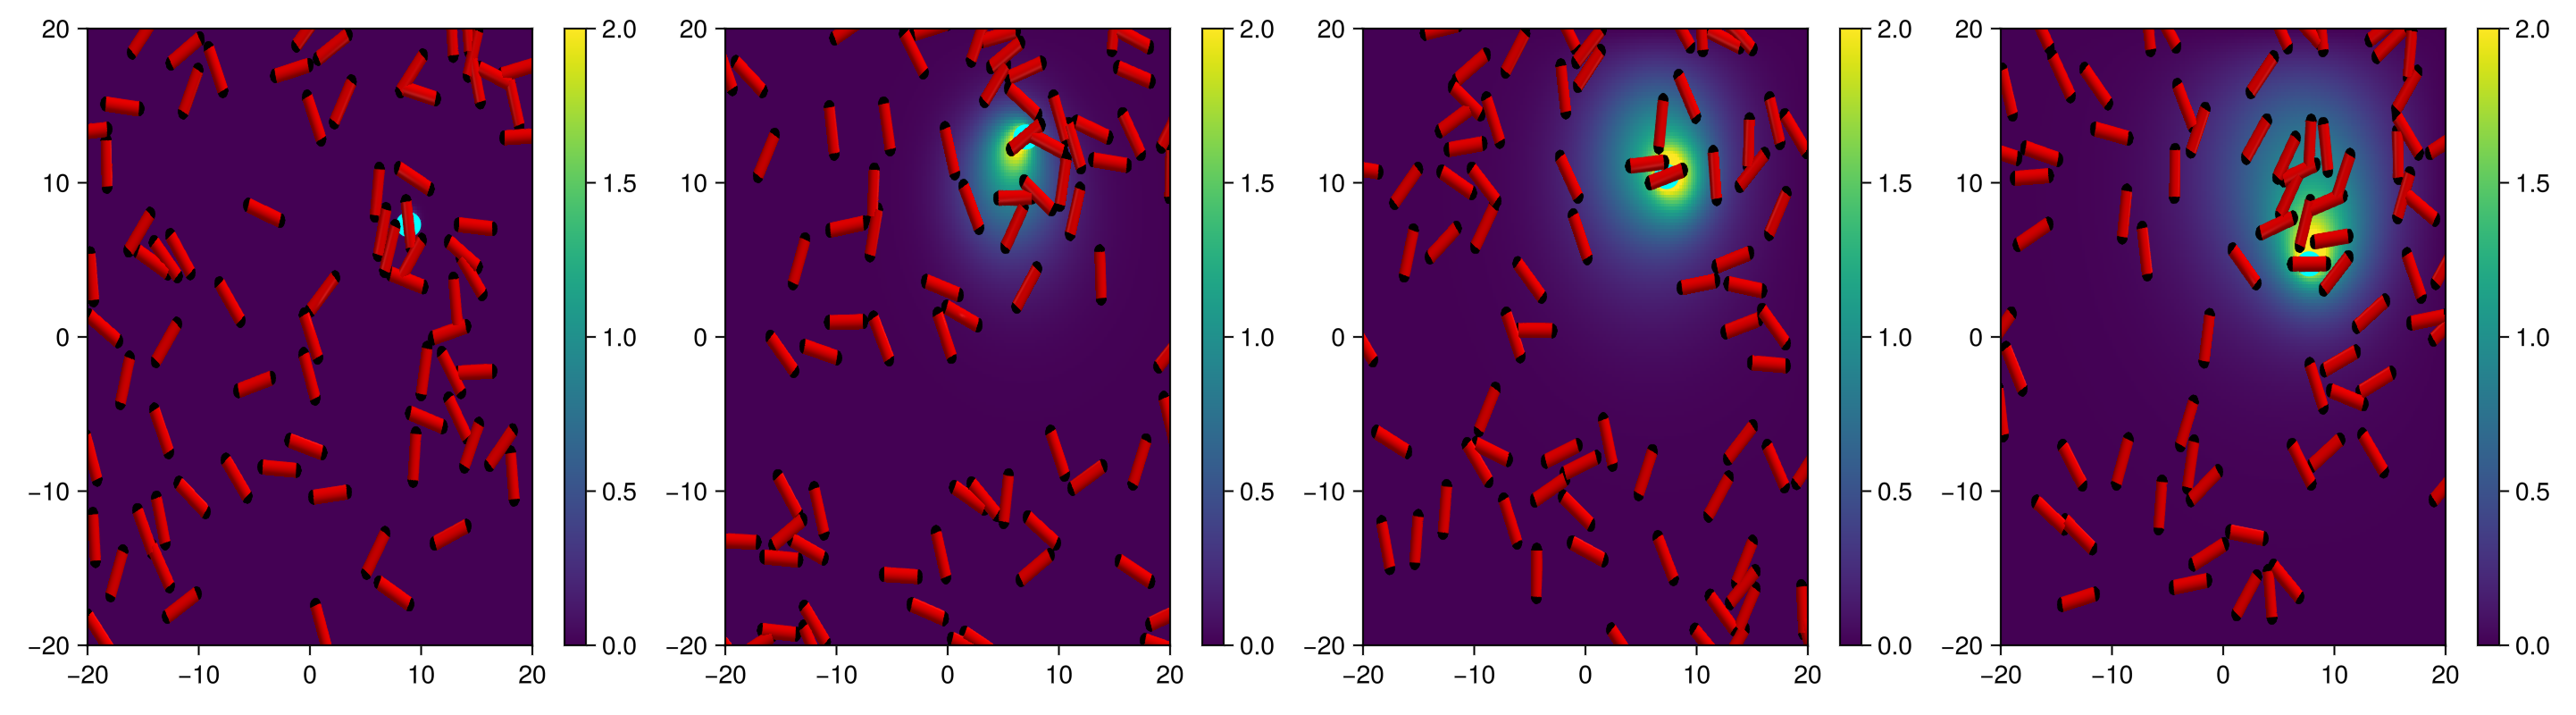

GLMakie.Screen(...)

In [11]:
fig = Figure(size=(1800, 400))

for (j,i) in enumerate(1:round(Int,length(com)/4):length(com))
    begin
        d = getParameter(com, [:x,:y,:d,:l,:theta,:pressure,:mm, :isSource])

        ax = Axis(fig[1,2*j-1])

        m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                d[:mm][i],
                colorrange=(0,2.)
        )

        xlims!(com.simBox[1,:]...)
        ylims!(com.simBox[2,:]...)

        src = findall(d[:isSource][i])
        scatter!(
            ax, 
            d[:x][i][src],
            d[:y][i][src],
            color = :cyan,
            markersize = 20
        )

        x = Observable(d[:x][i])
        y = Observable(d[:y][i])
        xs1 = Observable(d[:x][i]+d[:l][i]./2 .*cos.(d[:theta][i]))
        ys1 = Observable(d[:y][i]+d[:l][i]./2 .*sin.(d[:theta][i]))
        xs2 = Observable(d[:x][i]-d[:l][i]./2 .*cos.(d[:theta][i]))
        ys2 = Observable(d[:y][i]-d[:l][i]./2 .*sin.(d[:theta][i]))
        ms = Observable([Point3f(i/2,i/2,0) for i in d[:d][i]])
        mc = Observable([Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(d[:l][i],d[:d][i])])
        theta = Observable(d[:theta][i])

        plotRods2D!(ax,x,y,xs1,ys1,xs2,ys2,ms,mc,theta,color=:red)

        Colorbar(fig[1,2*j],m)


    end
end

display(fig)

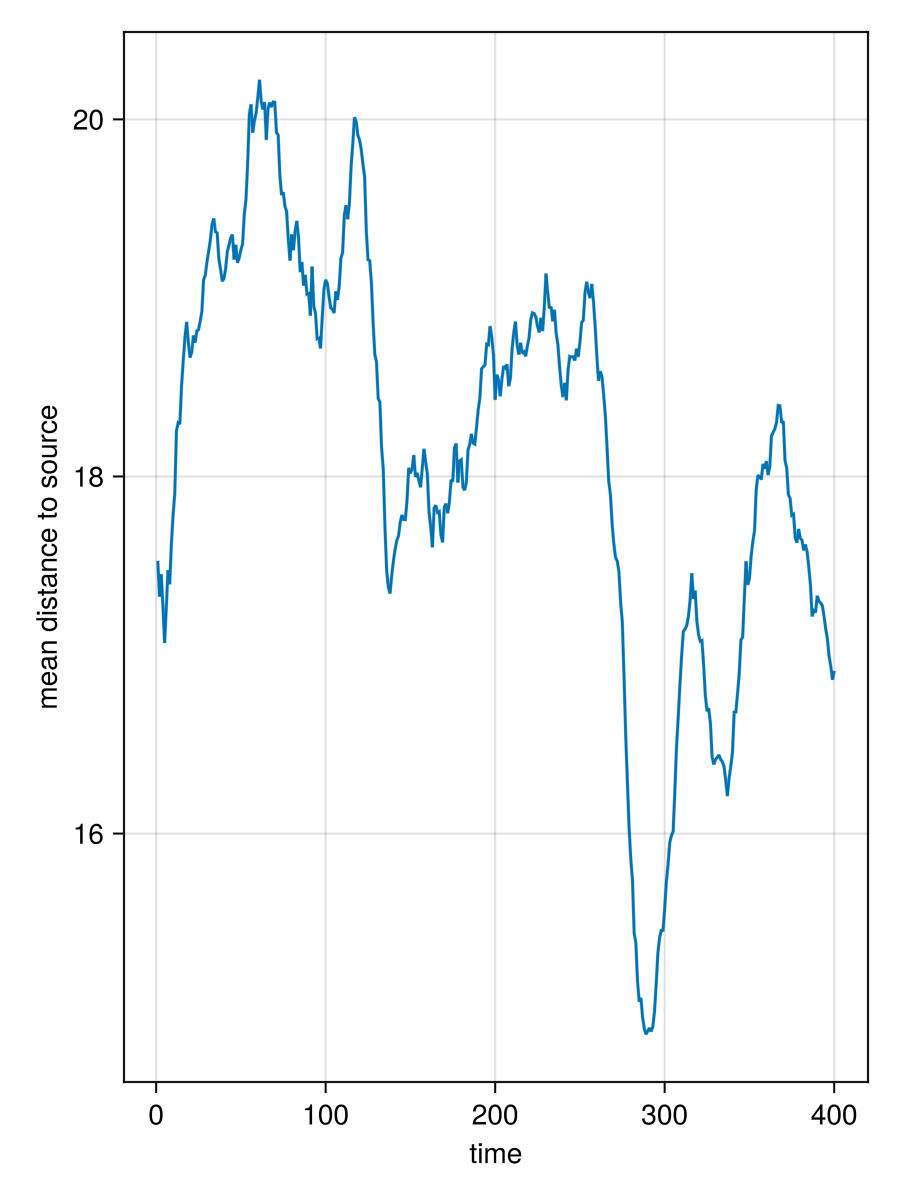

GLMakie.Screen(...)

In [12]:
using Statistics

d = getParameter(com, [:x, :y, :S, :isSource])

src_id = findfirst(d[:isSource][1])

t = [pt.t for pt in com.pastTimes]

# mean distance to source
mean_dist = [
    mean(
        sqrt.(
            (d[:x][k] .- d[:x][k][src_id]).^2 .+
            (d[:y][k] .- d[:y][k][src_id]).^2
        )[.!d[:isSource][k]]
    )
    for k in eachindex(t)
]

fig = Figure(size=(450, 600))

ax1 = Axis(fig[1,1], xlabel="time", ylabel="mean distance to source")
lines!(ax1, t, mean_dist)

display(fig)

Es veu que l'agent es mou per l'espai i deixa una estel·la. 

# Afegir un altre agent

In [3]:
rods2DChemotaxis_2 = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :theta => Float64,
        :ω => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        :tTumble => Float64,
        :active => Bool,

        :isSource => Bool,
        :S => Float64,

    ),

    model = Dict(
        :kn => Float64,
        :γn => Float64,
        :γt => Float64,
        :μcc => Float64,
        :μcw => Float64,
        :β => Float64,
        :βω => Float64,
        :ωTumble => Float64,
        :τTumble => Float64,
        :fChem => Float64,
        :DMedium => Float64,
        :DSource => Float64 #Diffusion of source for the random walk
    ),

    medium = Dict(
        :mm => Float64
    ),

    agentODE = quote
        fx = 0.0
        fy = 0.0
        W = 0.0
        pressure = 0.0

        @loopOverNeighbors j begin
            Fijx, Fijy, Wij = CBMModels.rodForces(
                x, y, d, l, theta, vx, vy, m,
                x[j], y[j], d[j], l[j], theta[j], vx[j], vy[j], m[j],
                kn, γn, γt, μcc, μcw
            )

            fx += Fijx
            fy += Fijy
            W += Wij
            pressure += sqrt(Fijx^2 + Fijy^2)
        end

        dt(x) = vx
        dt(y) = vy
        dt(vx) = -β * vx + fx / m + active * fChem * cos(theta) * mm #Added term so that S positive or negative has effect (have both attractant and repellant)
        dt(vy) = -β * vy + fy / m + active * fChem * sin(theta) * mm
        dt(theta) = ω
        dt(ω) = W / (m * (d + l)^2 / 12 + m * d^2) - βω * ω
    end,

    agentRule = quote

        if isSource
            σ = sqrt(2 * DSource / dt)

            vx = σ * randn()
            vy = σ * randn()
            ω = 0.0

            mm += S
        end

        if tTumble < t && active
            vx = 0.0
            vy = 0.0
            active = false
            ω += ωTumble
            tTumble += 1.0
        elseif tTumble < t && !active
            ω = 0.0
            active = true
            tTumble += CBMDistributions.exponential((2 - mm) * τTumble)
        end
 
        if x < simBox[1,1]
            x = simBox[1,1]
        elseif x > simBox[1,2]
            x = simBox[1,2]
        end
        if y < simBox[2,1]
            y = simBox[2,1]
        elseif y > simBox[2,2]
            y = simBox[2,2]
        end
    end,

    mediumODE = quote
        if @mediumInside()
            dt(mm) = DMedium *(@∂2(1, mm)+ @∂2(2, mm))
        end
    end,

    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	xₘ (Float64 medium)
	yₘ (Float64 medium)
	d (Float64 agent)
	active (Bool agent)
	isSource (Bool agent)
	fx (Float64 agent)
	vx (Float64 agent)
	l (Float64 agent)
	m (Float64 agent)
	fy (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	ω (Float64 agent)
	W (Float64 agent)
	S (Float64 agent)
	tTumble (Float64 agent)
	theta (Float64 agent)
	γn (Float64 model)
	μcw (Float64 model)
	ωTumble (Float64 model)
	β (Float64 model)
	DMedium (Float64 model)
	γt (Float64 model)
	μcc (Float64 model)
	kn (Float64 model)
	fChem (Float64 model)
	βω (Float64 model)
	DSource (Float64 model)
	τTumble (Float64 model)
	mm (Float64 medium)


UPDATE RULES
mediumODE
 if @mediumInside()
    dt__mm = DMedium * (@∂2(1, mm) + @∂2(2, mm))
end

agentRule
 begin
    if isSource
        σ = sqrt((2DSource) / dt)
        vx__ = σ * randn()
        vy__ = σ * randn()
        ω__ = 0.0
        mm__ += S
    end
    if tTumble < t && active
        vx__ = 0.0


In [7]:
com_2 = Community(
    rods2DChemotaxis_2;
    N = 75,
    dt = 0.1,
    simBox = [-20.0 20.0; -20.0 20.0],
    NMedium = [200, 200]
)

m = 1 / 100
g = 1 / 10000
d = 1.0

com_2.kn = 2e6 * (m * g / d)
com_2.γn = 2.2e2 * sqrt(g / d)
com_2.γt = 2.2e2 * sqrt(g / d)
com_2.μcc = 0.1
com_2.μcw = 0.8
com_2.β = 0.8
com_2.βω = 0.8
com_2.fChem = 1.0
com_2.τTumble = 2.0
com_2.ωTumble = 1.0
com_2.DMedium = 0.1
com_2.DSource = 0.063

com_2.m .= 1.0
com_2.d .= 1.0
com_2.l .= 3.0

com_2.x .= rand(Uniform(com_2.simBox[1, 1], com_2.simBox[1, 2]), com_2.N)
com_2.y .= rand(Uniform(com_2.simBox[2, 1], com_2.simBox[2, 2]), com_2.N)
com_2.theta .= rand(Uniform(0, 2π), com_2.N)

# Chemotaxis source agent
src1 = 1
src2 = 2

com_2.isSource .= false
com_2.isSource[src1] = true
com_2.isSource[src2] = true

com_2.active .= true 
com_2.active[src1] = false   
com_2.active[src2] = false

com_2.S .= 0.0

com_2.S[src1] = 2.0
com_2.S[src2] = -2.0


-2.0

In [8]:
evolve!(com_2, steps = 4000, saveEach = 10)

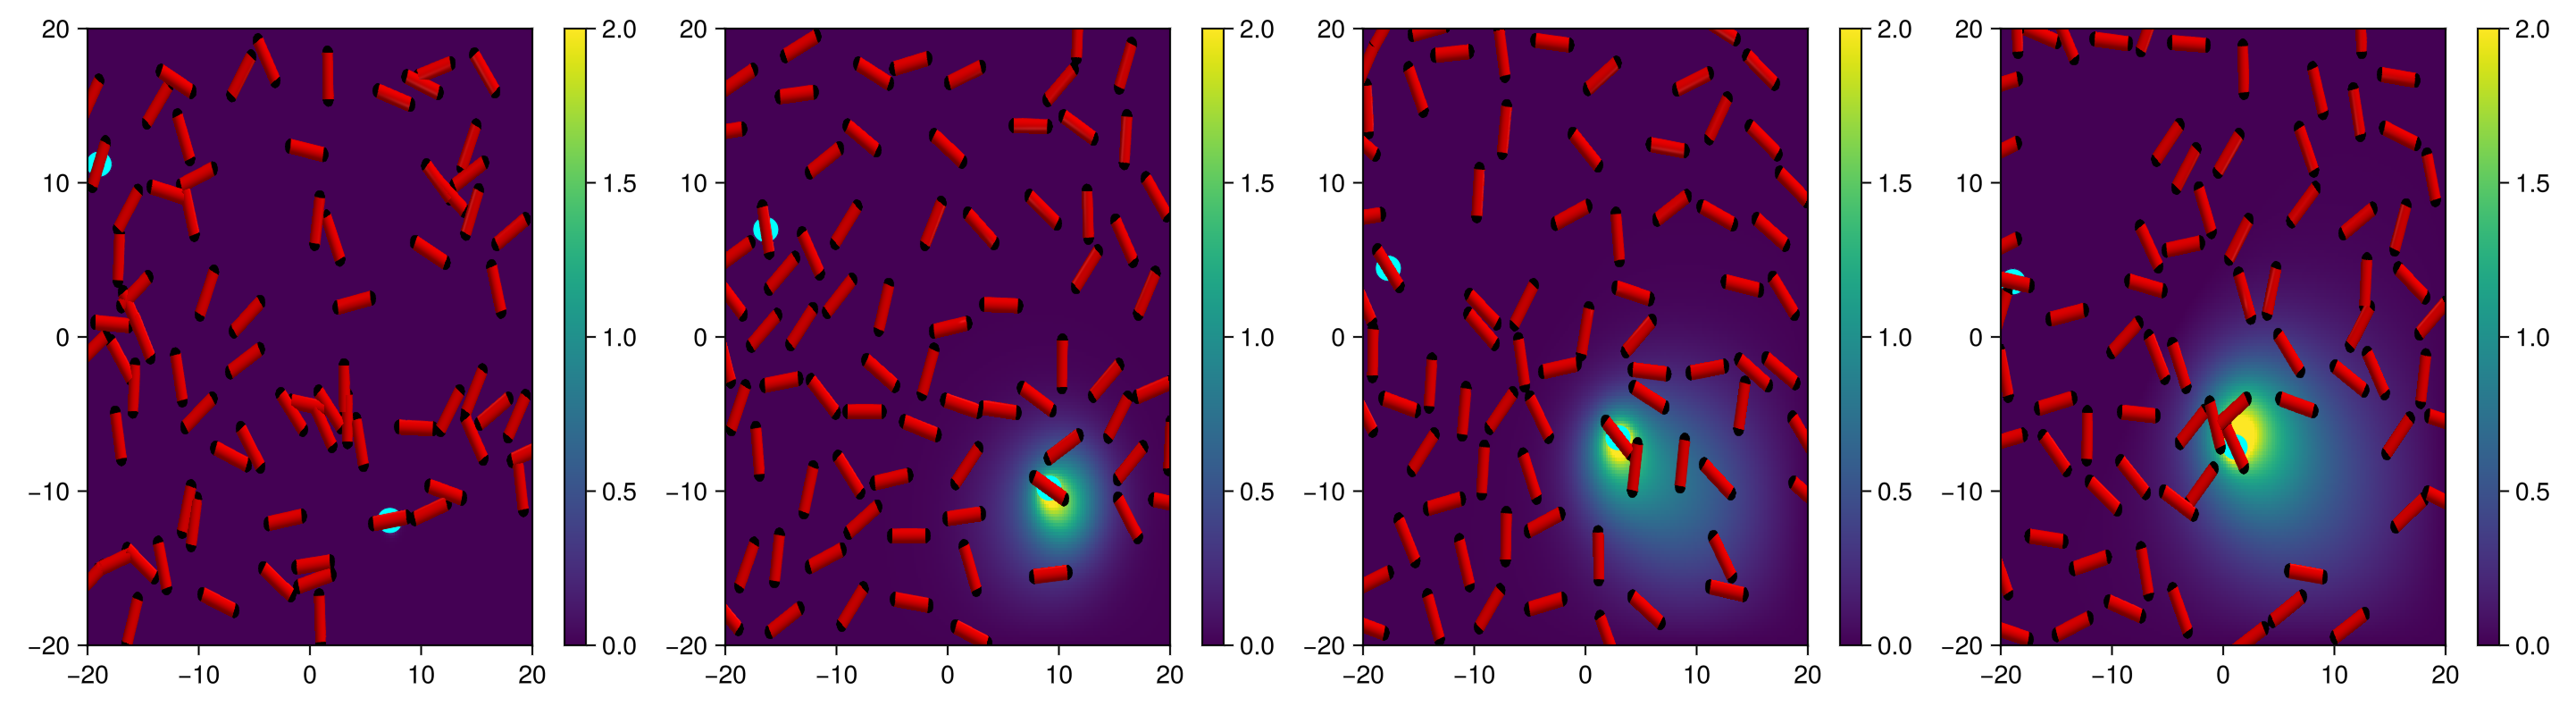

GLMakie.Screen(...)

In [9]:
fig = Figure(size=(1800, 400))

for (j,i) in enumerate(1:round(Int,length(com_2)/4):length(com_2))
    begin
        d = getParameter(com_2, [:x,:y,:d,:l,:theta,:pressure,:mm, :isSource])

        ax = Axis(fig[1,2*j-1])

        m = heatmap!(ax,
                range(com_2.simBox[1,1],com_2.simBox[1,2],length=size(com_2.mm)[1]),
                range(com_2.simBox[2,1],com_2.simBox[2,2],length=size(com_2.mm)[1]),
                d[:mm][i],
                colorrange=(0,2.)
        )

        xlims!(com_2.simBox[1,:]...)
        ylims!(com_2.simBox[2,:]...)

        src = findall(d[:isSource][i])
        scatter!(
            ax, 
            d[:x][i][src],
            d[:y][i][src],
            color = :cyan,
            markersize = 20
        )

        x = Observable(d[:x][i])
        y = Observable(d[:y][i])
        xs1 = Observable(d[:x][i]+d[:l][i]./2 .*cos.(d[:theta][i]))
        ys1 = Observable(d[:y][i]+d[:l][i]./2 .*sin.(d[:theta][i]))
        xs2 = Observable(d[:x][i]-d[:l][i]./2 .*cos.(d[:theta][i]))
        ys2 = Observable(d[:y][i]-d[:l][i]./2 .*sin.(d[:theta][i]))
        ms = Observable([Point3f(i/2,i/2,0) for i in d[:d][i]])
        mc = Observable([Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(d[:l][i],d[:d][i])])
        theta = Observable(d[:theta][i])

        plotRods2D!(ax,x,y,xs1,ys1,xs2,ys2,ms,mc,theta,color=:red)

        Colorbar(fig[1,2*j],m)


    end
end

display(fig)

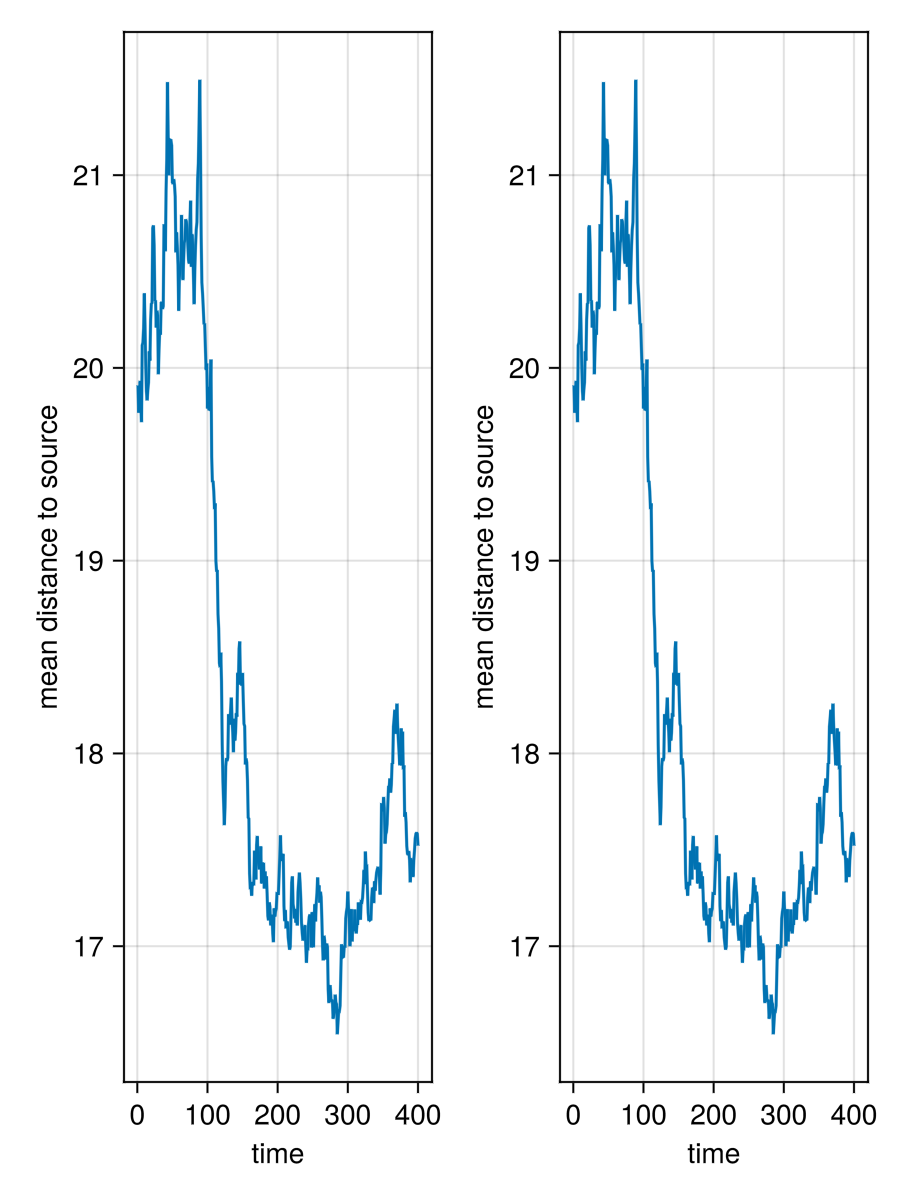

GLMakie.Screen(...)

In [10]:
using Statistics

d = getParameter(com_2, [:x, :y, :S, :isSource])

src_id = findfirst(d[:isSource][1])
src_id_2 = findfirst(d[:isSource][2])

t = [pt.t for pt in com_2.pastTimes]

# mean distance to source
mean_dist_1 = [
    mean(
        sqrt.(
            (d[:x][k] .- d[:x][k][src_id]).^2 .+
            (d[:y][k] .- d[:y][k][src_id]).^2
        )[.!d[:isSource][k]]
    )
    for k in eachindex(t)
]
mean_dist_2 = [
    mean(
        sqrt.(
            (d[:x][k] .- d[:x][k][src_id_2]).^2 .+
            (d[:y][k] .- d[:y][k][src_id_2]).^2
        )[.!d[:isSource][k]]
    )
    for k in eachindex(t)
]

fig = Figure(size=(450, 600))

ax1 = Axis(fig[1,1], xlabel="time", ylabel="mean distance to source")
lines!(ax1, t, mean_dist_1)

ax2 = Axis(fig[1,2], xlabel="time", ylabel="mean distance to source")
lines!(ax2, t, mean_dist_2)

display(fig)